## Dependencies and data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RP_helpers as rp
#from importlib import reload
#reload(rp)

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## Cleaning

In [3]:
loans.columns = loans.columns.str.strip()
loans.drop("loan_id", axis=1, inplace=True)
loans.drop("cibil_score", axis=1, inplace=True) # Only consider 1st time applicants

loans['education'] = loans['education'].str.strip()
loans['self_employed'] = loans['self_employed'].str.strip()
loans['loan_status'] = loans['loan_status'].str.strip()

loans["education"] = loans["education"].replace({"Graduate" : 1, "Not Graduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})

loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,12400000,8200000,29400000,5000000,0


## Exploration

In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   no_of_dependents          4269 non-null   int64
 1   education                 4269 non-null   int64
 2   self_employed             4269 non-null   int64
 3   income_annum              4269 non-null   int64
 4   loan_amount               4269 non-null   int64
 5   loan_term                 4269 non-null   int64
 6   residential_assets_value  4269 non-null   int64
 7   commercial_assets_value   4269 non-null   int64
 8   luxury_assets_value       4269 non-null   int64
 9   bank_asset_value          4269 non-null   int64
 10  loan_status               4269 non-null   int64
dtypes: int64(11)
memory usage: 367.0 KB


In [5]:
loans.describe().applymap("{:,.1f}".format)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,"4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0"
mean,2.5,0.5,0.5,"5,059,123.9","15,133,450.5",10.9,"7,472,616.5","4,973,155.3","15,126,305.9","4,976,692.4",0.6
std,1.7,0.5,0.5,"2,806,839.8","9,043,363.0",5.7,"6,503,636.6","4,388,966.1","9,103,753.7","3,250,185.3",0.5
min,0.0,0.0,0.0,"200,000.0","300,000.0",2.0,"-100,000.0",0.0,"300,000.0",0.0,0.0
25%,1.0,0.0,0.0,"2,700,000.0","7,700,000.0",6.0,"2,200,000.0","1,300,000.0","7,500,000.0","2,300,000.0",0.0
50%,3.0,1.0,1.0,"5,100,000.0","14,500,000.0",10.0,"5,600,000.0","3,700,000.0","14,600,000.0","4,600,000.0",1.0
75%,4.0,1.0,1.0,"7,500,000.0","21,500,000.0",16.0,"11,300,000.0","7,600,000.0","21,700,000.0","7,100,000.0",1.0
max,5.0,1.0,1.0,"9,900,000.0","39,500,000.0",20.0,"29,100,000.0","19,400,000.0","39,200,000.0","14,700,000.0",1.0


In [6]:
loans.nunique()

no_of_dependents              6
education                     2
self_employed                 2
income_annum                 98
loan_amount                 378
loan_term                    10
residential_assets_value    278
commercial_assets_value     188
luxury_assets_value         379
bank_asset_value            146
loan_status                   2
dtype: int64

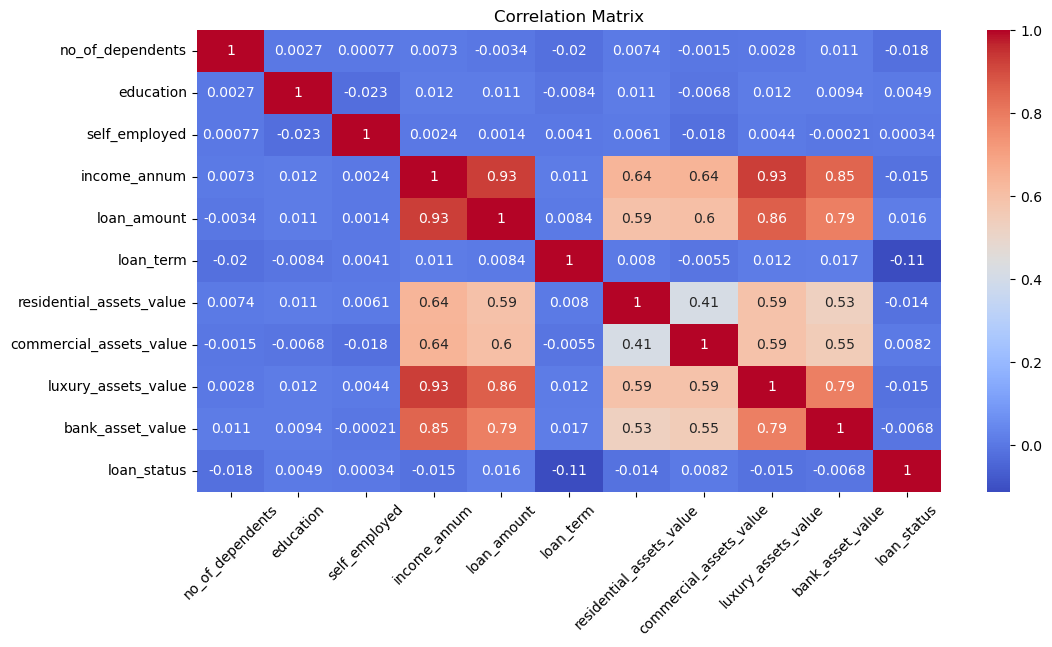

In [7]:
corr_matrix = loans.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

## Initial model testing

In [8]:
#loan_status
#1    2656
#0    1613
#1043

X = loans.drop("loan_status", axis=1)
y = loans["loan_status"]

# One-hot encode no_of_dependents
X_onehot = pd.get_dummies(X, columns=["no_of_dependents"])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_onehot)

# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1234, test_size=0.3)

# Balancing with smote
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Balancing by dropping randomly
indices_to_drop = np.where(y_train == 1)[0]
indices_to_keep = np.random.choice(indices_to_drop, size=len(indices_to_drop)-1043, replace=False)
X_train_drop = np.delete(X_train, indices_to_keep, axis=0)
y_train_drop = np.delete(y_train, indices_to_keep, axis=0)

# Comparing accuracies
accs = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "mlp":0, "xgb":0}
accs_smote = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "mlp":0, "xgb":0}
accs_drop = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "mlp":0, "xgb":0}

In [9]:
knn = KNeighborsClassifier(n_neighbors=7)
accs["knn"] = cross_val_score(knn, X_train, y_train).mean()
accs_smote["knn"] = cross_val_score(knn, X_train_smote, y_train_smote).mean()
accs_drop["knn"] = cross_val_score(knn, X_train_drop, y_train_drop).mean()

In [10]:
lr = LogisticRegression(random_state=1234)
accs["lr"] = cross_val_score(lr, X_train, y_train).mean()
accs_smote["lr"] = cross_val_score(lr, X_train_smote, y_train_smote).mean()
accs_drop["lr"] = cross_val_score(lr, X_train_drop, y_train_drop).mean()

In [11]:
dtc = DecisionTreeClassifier(random_state=1234, max_depth=4, min_samples_leaf=3)
accs["dtc"] = cross_val_score(dtc, X_train, y_train).mean()
accs_smote["dtc"] = cross_val_score(dtc, X_train_smote, y_train_smote).mean()
accs_drop["dtc"] = cross_val_score(dtc, X_train_drop, y_train_drop).mean()

In [12]:
rfc = RandomForestClassifier(n_estimators=100, random_state=1234)
accs["rfc"] = cross_val_score(rfc, X_train, y_train).mean()
accs_smote["rfc"] = cross_val_score(rfc, X_train_smote, y_train_smote).mean()
accs_drop["rfc"] = cross_val_score(rfc, X_train_drop, y_train_drop).mean()

In [13]:
svc = SVC(kernel="linear")
accs["svc"] = cross_val_score(svc, X_train, y_train).mean()
accs_smote["svc"] = cross_val_score(svc, X_train_smote, y_train_smote).mean()
accs_drop["svc"] = cross_val_score(svc, X_train_drop, y_train_drop).mean()

In [14]:
mlp = MLPClassifier(activation='identity', solver='sgd', random_state=1234)
accs["mlp"] = cross_val_score(mlp, X_train, y_train).mean()
accs_smote["mlp"] = cross_val_score(mlp, X_train_smote, y_train_smote).mean()
accs_drop["mlp"] = cross_val_score(mlp, X_train_drop, y_train_drop).mean()

In [15]:
xgb = XGBClassifier()
accs["xgb"] = cross_val_score(xgb, X_train, y_train).mean()
accs_smote["xgb"] = cross_val_score(xgb, X_train_smote, y_train_smote).mean()
accs_drop["xgb"] = cross_val_score(xgb, X_train_drop, y_train_drop).mean()

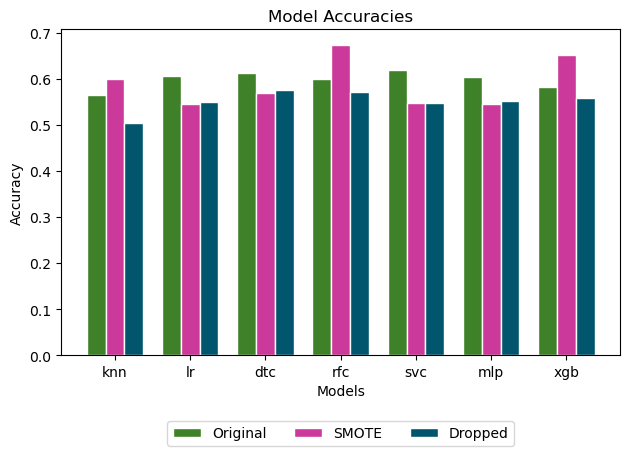

In [16]:
rp.plot_multi_bar_graph([accs, accs_smote, accs_drop], ["Original", "SMOTE", "Dropped"])

### Todo
- feature selection
- dimensionality reduction
- hyperparameter tuning
- Ensemble Methods

## Feature selection
#### Using the best performing featureset for each model (X_train, X_train_smote, X_train_drop)

In [17]:
knn_sfs = SFS(
    knn,
    k_features=(1, X_train_smote.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
knn_sfs.fit(X_train_smote, y_train_smote)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=7),
                          k_features=(1, 15), n_jobs=-1, scoring='accuracy')

In [18]:
lr_sfs = SFS(
    lr,
    k_features=(1, X_train.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
lr_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=1234),
                          k_features=(1, 15), n_jobs=-1, scoring='accuracy')

In [19]:
dtc_sfs = SFS(
    dtc,
    k_features=(1, X_train.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
dtc_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(max_depth=4,
                                                           min_samples_leaf=3,
                                                           random_state=1234),
                          k_features=(1, 15), n_jobs=-1, scoring='accuracy')

In [49]:
rfc_sfs = SFS(
    rfc,
    k_features=(1, X_train_smote.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
rfc_sfs_back = SFS(
    rfc,
    k_features=(1, X_train_smote.shape[1]),
    forward=False,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
rfc_sfs.fit(X_train_smote, y_train_smote)
rfc_sfs_back.fit(X_train_smote, y_train_smote)

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=1234),
                          forward=False, k_features=(1, 15), n_jobs=-1,
                          scoring='accuracy')

In [21]:
svc_sfs = SFS(
    svc,
    k_features=(1, X_train.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
svc_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=SVC(kernel='linear'), k_features=(1, 15),
                          n_jobs=-1, scoring='accuracy')

In [44]:
# This is super slow

#mlp_sfs = SFS(
#    mlp,
#    k_features=(1, X_train.shape[1]),
#    forward=True,
#    scoring="accuracy",
#    cv=5,
#    verbose=1,
#    n_jobs=-1
#)
#mlp_sfs.fit(X_train, y_train)

In [45]:
#This is super slow

#xgb_sfs = SFS(
#    xgb,
#    k_features=(1, X_train_smote.shape[1]),
#    forward=True,
#    scoring="accuracy",
#    cv=5,
#    verbose=1,
#    n_jobs=-1
#)
#xgb_sfs.fit(X_train_smote, y_train_smote)

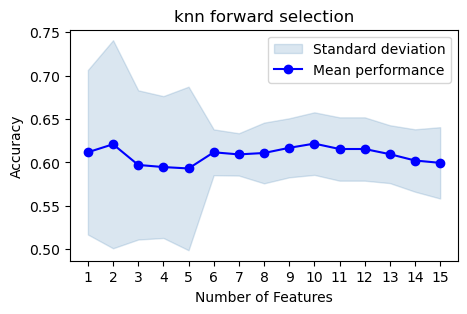

In [36]:
plot_sfs(knn_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("knn forward selection")
plt.legend(["Standard deviation", "Mean performance"])

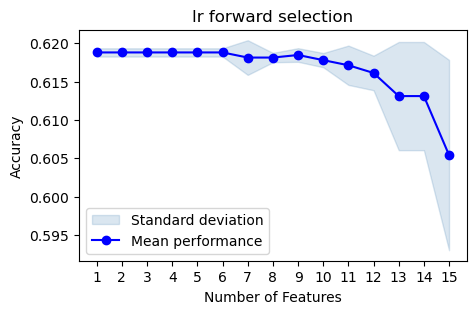

In [37]:
plot_sfs(lr_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("lr forward selection")
plt.legend(["Standard deviation", "Mean performance"])

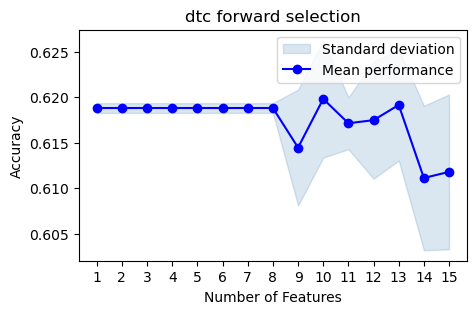

In [38]:
plot_sfs(dtc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("dtc forward selection")
plt.legend(["Standard deviation", "Mean performance"])

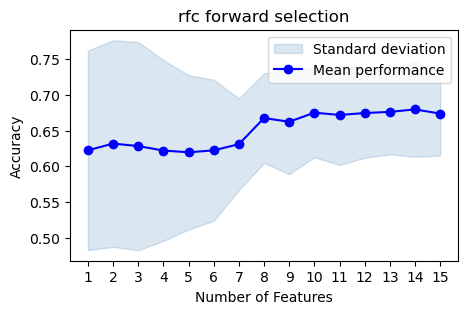

In [47]:
plot_sfs(rfc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("rfc forward selection")
plt.legend(["Standard deviation", "Mean performance"])

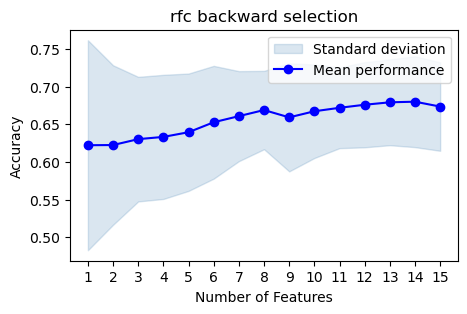

In [50]:
plot_sfs(rfc_sfs_back.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("rfc backward selection")
plt.legend(["Standard deviation", "Mean performance"])

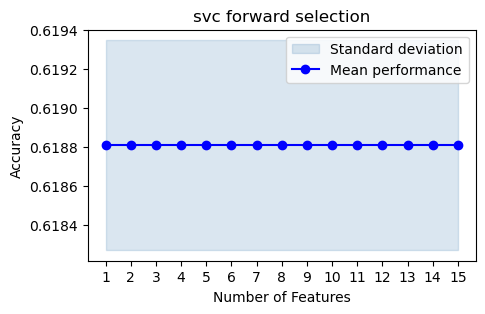

In [48]:
plot_sfs(svc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("svc forward selection")
plt.legend(["Standard deviation", "Mean performance"])

## Hyperparameter optimization

In [57]:
# rfc_sfs
X_train_smote_rfc = rfc_sfs.transform(X_train_smote)
X_test_rfc = rfc_sfs.transform(X_test)

In [71]:
param_grid = {
    'n_estimators': [175, 180, 185, 190],
    'max_depth': [None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2'],
    'criterion': ['gini']
}

# Create a GridSearchCV object and fit it to your data
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring="accuracy",refit=True, n_jobs=-1, verbose=1)
grid_search.fit(X_train_smote_rfc, y_train_smote)

# Retrieve the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 185}
Best Score:  0.6917660827268405
